![Py4Eng](img/logo.png)

# Statistics
## Yoav Ram

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy.special as spec
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)

Some of the presented exercises follow that wonder [IPython Cookbook](http://ipython-books.github.io/cookbook/) by [Cyrille Rossant](http://cyrille.rossant.net/).

# One sample mean hypothesis tests

Let's write a function that flips a coin `n` times and returns the number of times it landed on *head*. It's a special coin - the probability that it falls on *head* is `p`:

In [2]:
def flip(n, q=0.5):
    return (np.random.rand(n) < q).sum()

In [3]:
np.random.seed(847)
flips = 100
q = 0.5
heads = flip(flips, q=0.54)
heads

61

Say we don't know what `q` is and we want to check if the coin is fair - that is, if `q` is 0.5. We can use a *hypothesis test* for this purpose. 

Our *null hypothesis* is $H_0: q=0.5$, whereas our alternative hypothesis is $H_A: q \ne 0.5$.

To test this hypothesis, we need to calculate a test statistic. In this case, we use the *z-test*, in which the statistic is the normalized fraction of heads:
$$
z = \frac{\bar{x} - E[\bar{x}]}{std(\bar{x}} = (\bar{x} - q) \sqrt{\frac{n}{q(1-q)}}
$$
where $\bar{x}$ is the fraction of flips in which we got *head*.

In [4]:
xbar = heads / flips
z = (xbar - q) * np.sqrt(flips / (q * (1 - q)))
z

2.1999999999999997

Because of the way we calculated $z$, we know that if the null hypothesis is true, then `z` is drawn from a standard normal distribution (at least for large `n`, due to the *Central Limit Theorem*).

Therefore, we can calculate the *P-value*, or the probability to get a value more extreme than `z`:

$$
p = P(|Z| > z) \approx 2 ( 1 - \phi(z) )
$$
where $\phi$ is the *cummulative probabiltiy function* of the standard normal distribution.

P-value: 0.028, Reject null hypothesis: True


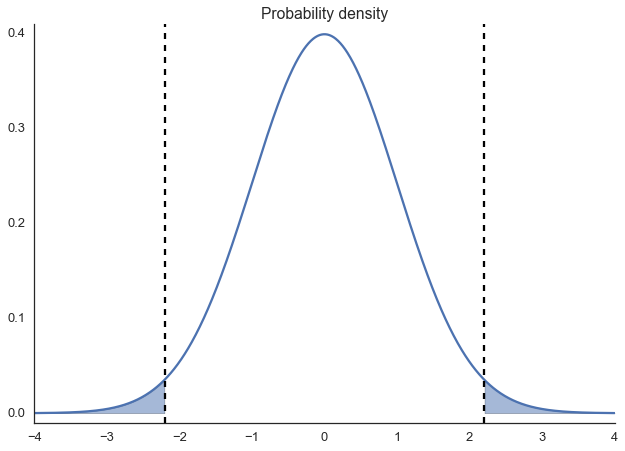

In [5]:
Z = stats.norm(0, 1)
t = np.linspace(-4, 4, 1000)

fig, ax = plt.subplots()

ax.plot(t, Z.pdf(t))
ax.axvline(z, color='k', ls='--')
ax.axvline(-z, color='k', ls='--')
ax.fill_between(t[t>z], Z.pdf(t[t>z]), alpha=0.5)
ax.fill_between(t[t<-z], Z.pdf(t[t<-z]), alpha=0.5)

ax.set(
    title='Probability density',
    ylim=(-0.01, 0.41)
)

sns.despine()

pval = 2 * (1 - stats.norm.cdf(z))
print("P-value: {0:.2g}, Reject null hypothesis: {1}".format(pval, pval < 0.05))

## Exercise

Consider `x`, an array of 50 experimental measurements. We would like to use a t-test to test the null hypothesis that the expected/real value of the measurement is 75. 

Use the function `scipy.stats.ttest` to calculate a P-value and make an hypothesis test (with a significance level of 0.05).

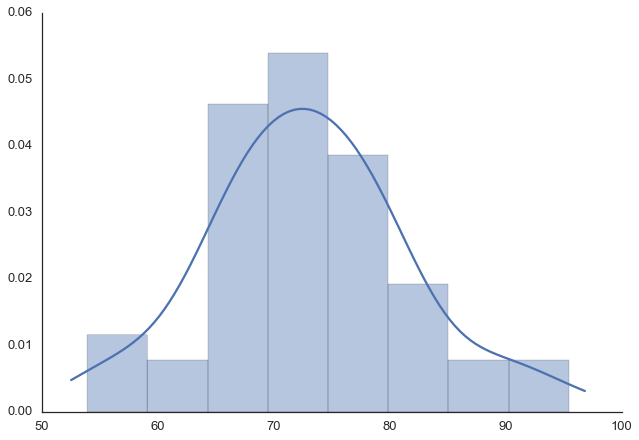

In [6]:
x = np.array([ 65.53023244,  72.23747986,  73.01265677,  89.9351998 ,
        70.6963815 ,  78.02590763,  81.2881422 ,  61.80569525,
        65.93705786,  70.54059758,  77.49758326,  68.42851182,
        68.55585283,  80.1871511 ,  74.65777598,  65.20851364,
        68.50039697,  65.90256468,  73.32305696,  74.03947153,
        77.1472388 ,  72.02604829,  82.7751142 ,  59.6132927 ,
        55.048079  ,  70.01523156,  90.5524559 ,  73.56715484,
        65.19466857,  76.66137409,  71.11086989,  58.7251773 ,
        53.9227519 ,  78.80348065,  65.70707516,  71.64598738,
        78.4655557 ,  68.55593575,  95.4389177 ,  65.28104808,
        79.67603416,  73.25855752,  67.59741922,  88.1492883 ,
        83.2779776 ,  80.9657968 ,  72.18488899,  76.23291307,
        76.50505861,  76.31360889])
sns.distplot(x)
sns.despine()

# Correlation

Next, we will use some tennis data to show how to calculate correlations and their statistical significance.

Start by downloading the data from the [IPython Cookbook: example data](https://github.com/ipython-books/cookbook-data) repo.

In [7]:
import urllib.request
import os.path
import zipfile
import pandas as pd

In [8]:
filename = r'..\data\tennis.zip'
if not os.path.exists(filename):
    urllib.request.urlretrieve('https://github.com/ipython-books/cookbook-data/raw/master/tennis.zip', filename)

zf = zipfile.ZipFile(filename)
for f in zf.filelist: 
    print(f.filename)

data/Andy-Murray.csv
data/Novak-Djokovic.csv
data/Rafael-Nadal.csv
data/Roger-Federer.csv


We have data for four prolific tennis player. We'll go with the Spanish sensation, Rafael Nadal.

In [9]:
player = 'Novak Djokovic'
with zf.open('data/{}.csv'.format(player.replace(' ', '-'))) as f:
    df = pd.read_csv(f)
df.head()

,year,tournament,start date,type,surface,draw,atp points,atp ranking,tournament prize money,round,...,player2 2nd serve return points total,player2 break points converted won,player2 break points converted total,player2 return games played,player2 total service points won,player2 total service points total,player2 total return points won,player2 total return points total,player2 total points won,player2 total points total
0,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709,$480,R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709,$480,R16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709,$480,Q,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709,$480,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003,"Serbia F5, Beograd",21.07.2003,FU,Outdoor: Clay,Draw: 32,NaN,774,$118,R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We'll start by plotting the % of points won by Novak vs the % of points he aced.

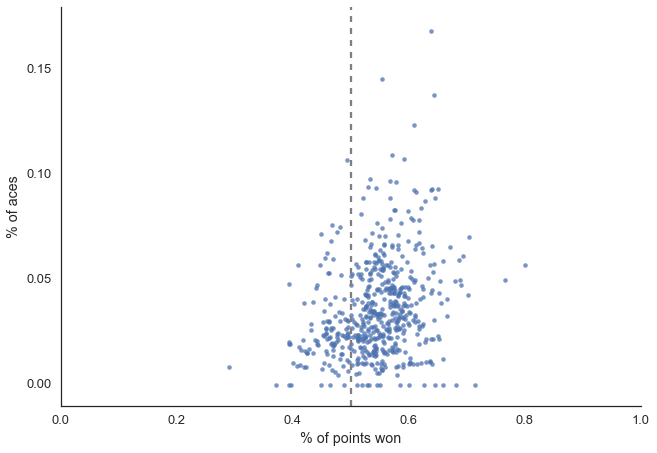

In [10]:
npoints = df['player1 total points total']
points = df['player1 total points won'] / npoints
aces = df['player1 aces'] / npoints

fig, ax = plt.subplots()
ax.plot(points, aces, '.', alpha=0.75)
ax.axvline(0.5, ls='--', color='gray')
ax.set(
    xlabel='% of points won',
    ylabel='% of aces',
    xlim=(0, 1),
    ylim=-0.01
)
sns.despine()

Let's calculate the *correlation* between % points won and % of aces. We use [*Pearson's linear correlation*](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient). 

First, we create a new data frame just with the relevant data:

In [11]:
df_bis = pd.DataFrame(
    {
        'points': points, 
        'aces': aces
    }
).dropna()
df_bis.tail()

,aces,points
725,0.059322,0.686441
726,0.066372,0.557522
727,0.015873,0.555556
728,0.031884,0.533333
729,0.024390,0.523035


Then we calculate the (symmetric) correlation matrix:

In [12]:
df_bis.corr() # default method is "pearson"

,aces,points
aces,1.000000,0.280572
points,0.280572,1.000000


A correlation coefficient of 0.28 is suggestive of a positive correlation. 

We want to estimate the statistically significance of the correlation between the variables.
For this purpose we use a *chi-squared test* of the independence of variables in a contingency table.

First, we binarize our variables. Here, the value corresponding to the number of aces is `True` if the player is serving more aces than usual in a match, and `False` otherwise. Similarly, we define the `result` as `True` if the % of points is larger than usual and `False` otherwise.

We then create a contingency table:

In [13]:
df_bis['result'] = df_bis['points'] > df_bis['points'].median()
df_bis['manyaces'] = df_bis['aces'] > df_bis['aces'].median()

contab = pd.crosstab(df_bis['result'], df_bis['manyaces'])
contab

manyaces,False,True
result,,
False,178,105
True,105,177


It's easy to see that the main diagonal (`False-False` and `True-True`) is heavier then the rest of the table. To quantify this, we use the `ch2_contingency` function to calculate the P-value: the probability to get this table given the null hypothesis that above aces and points are independent:

In [14]:
chi2, p, dof, ex = stats.chi2_contingency(contab)
print("P-value: {0:.2g}, Reject null hypothesis: {1}".format(p, p < 0.05))

P-value: 1.8e-09, Reject null hypothesis: True


## Exercise

It is commonly said that [Rafael Nadal](https://en.wikipedia.org/wiki/Rafael_Nadal) is the most dominant clay player in the world.

![Rafa on clay](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/Nadal_2010_Madrid_01.jpg/330px-Nadal_2010_Madrid_01.jpg)

Let's examine if indeed there is a correlation between the surface Rafa plays on and his winning.

The following cell loads the data for Rafa, discards surfaces on which he played less than 100 matches, and plots a bar plots of the results

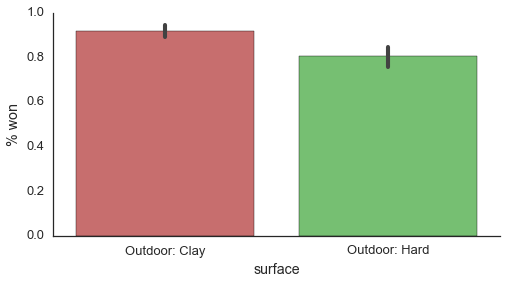

In [15]:
player = 'Rafael Nadal'
with zf.open('data/{}.csv'.format(player.replace(' ', '-'))) as f:
    df = pd.read_csv(f)

surface_count = df['surface'].value_counts()
surfaces = surface_count[surface_count > 100].index
df = df[df['surface'].isin(surfaces)]
df['win'] = df.winner == player

fig = plt.figure(figsize=(8, 4))
_, green, red = sns.color_palette('muted', 3)
sns.set_palette([red, green])
sns.barplot('surface', 'win', data=df)
plt.ylabel('% won')
sns.despine()

Indeed it seems that the probability of winning is higher on Clay for Rafa. 

Use a contingency table to perform a *chi-sqaure* to test the null hypothesis that winning is independent of surface for Rafa.

In [16]:
contab = pd.crosstab(df['win'], df['surface'])
contab

surface,Outdoor: Clay,Outdoor: Hard
win,,
False,28,64
True,329,268


In [17]:
chi2, p, dof, ex = stats.chi2_contingency(contab)
print("P-value: {0:.2g}, Reject null hypothesis: {1}".format(p, p < 0.05))

P-value: 1.7e-05, Reject null hypothesis: True


# Estimating distributions

*SciPy* has builtin functions to estimate probability distributions from data using [*Maximum Likelihood Estimators*](http://en.wikipedia.org/
wiki/Maximum_likelihood) (MLE).

Let's load some transplant survival data (originally from *Miller, R. (1976). Least squares regression with censored dara. Biometrica, 63 (3). 449-464*). This data contains the survival time after receiving a heart transplant.

In [19]:
df = pd.read_csv(r'../data/heart.csv')
df.head()

,survival
0,15
1,3
2,624
3,46
4,127


We start by plotting the survival data for each patient, by descending survival, and the histogram of the survival data.

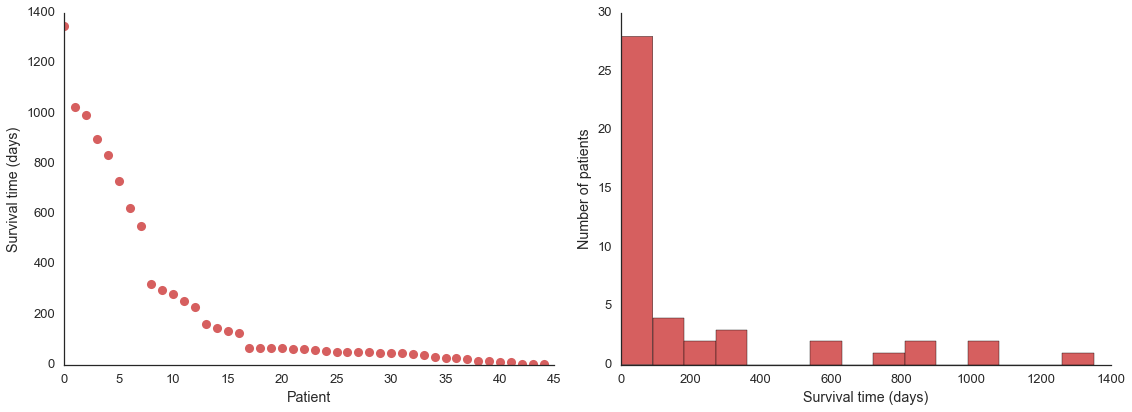

In [20]:
survival = df.survival

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(sorted(survival)[::-1], 'o')
ax[0].set(xlabel='Patient', ylabel='Survival time (days)')

ax[1].hist(survival, bins=15)
ax[1].set(xlabel='Survival time (days)', ylabel='Number of patients')

fig.tight_layout()
sns.despine()

It seems that the histogram is decreasing rapidly (this is data from the 1970's), so we will try to fit an exponential distribution to the data.

We do this using the `scipy.stats.expon` class which has a `fit` class method (as do all the distribution classes). This function calculates a MLE of the distribution and returns the distribution paramters (the location and scale, in this case).

We then plot then create an instance of the exponential distribution with the estimated parameters and plot the distribution (using the `pdf` method) in comparison to the data:

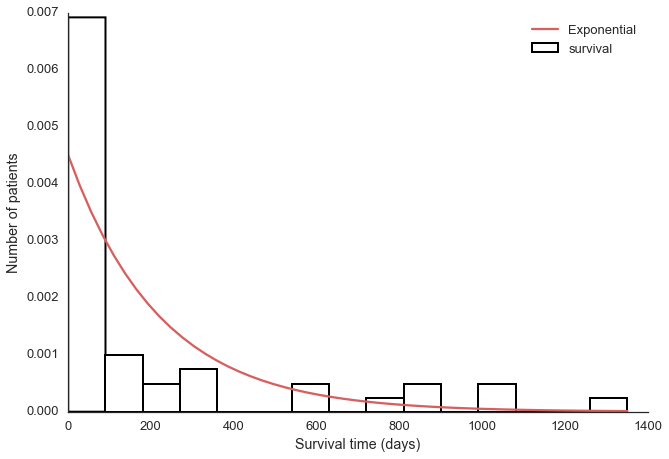

In [21]:
params = stats.expon.fit(survival)
exp_dist = stats.expon(*params)

srange = np.linspace(survival.min(), survival.max())

fig, ax = plt.subplots()
ax.plot(srange, exp_dist.pdf(srange), label='Exponential')
ax.hist(survival, bins=15, normed=True, color='w', lw=2)
ax.set(xlabel='Survival time (days)', ylabel='Number of patients')

ax.legend()
sns.despine()

This doesn't look that good. A statistical test for the fit of the distribution to the data (a statistical quantification to the statement "this doesn't look that good") can be done with the [Kolmogorov-Smirnov goodness of fit test](http://en.wikipedia.org/
wiki/Kolmogorov-Smirnov_test) implemented in the `scipy.stats.kstest` function). The null hypothesis in this case is that the data came from the estimated exponential distribution.

In [22]:
D, p = stats.kstest(survival, exp_dist.cdf)
print("Exponential distribution")
print("P-value: {0:.2g}, reject null hypothesis: {1}".format(p, p < 0.05))


Exponential distribution
P-value: 8.6e-06, reject null hypothesis: True


Indeed, we reject the null hypothesis. 

## Exercise

Let's try a different distribution, the [fatigue life distribution](https://en.wikipedia.org/wiki/Birnbaum%E2%80%93Saunders_distribution), used extensively in reliability applications to model failure times.

Fit the distribution to the data, test it with the `kstest`, and plot it with the data and the exponential distribution for comparison.

**Note** the fatigue-life distribution has three parameters wehreas the exponential distribution has two, so we should probably use another statistical method to decide on the correct model.

# Estimating a probability distribution with a kernel density estimation

Sometimes we don't have an idea as to what is the *real* distribution the data came from. In these cases we can perform aparameteric estimation to fit an arbitrary family of function to the data distribution. 

Here, we use a *kernel density estimation* (KDE) to estimate the density of probability of a spatial distribution. We look at the geographical locations of tropical cyclones from 1848 to 2013, based on data provided by the NOAA, the US' National Oceanic and Atmospheric Administration.

We'll need the `Basemap` package, which is a *Matplotlib* add-on that displays maps. The easiest way to install it on Windows is to get a *wheel* installer from [Gohlke's website](http://www.lfd.uci.edu/~gohlke/pythonlibs/#basemap) and install with `pip install <path to downloaded wheel file>` (because at the time of writing, _conda_ didn't support `Basemap` on Windows with Python 3). The download might take about 20 mins. On non-Windows platforms `conda install basemap` should do the trick.

In [24]:
from mpl_toolkits.basemap import Basemap
sns.set_palette('muted')

We load the storms data set from the [IPython Cookbook data repo](https://github.com/ipython-books/cookbook-data).

In [26]:
filename = r'..\data\storms.zip'
if not os.path.exists(filename):
    urllib.request.urlretrieve('https://github.com/ipython-books/cookbook-data/raw/master/storms.zip', filename)

zf = zipfile.ZipFile(filename)
with zf.open('data/Allstorms.ibtracs_wmo.v03r05.csv') as f:
    df = pd.read_csv(f)
df.head()

,Serial_Num,Season,Num,Basin,Sub_basin,Name,ISO_time,Nature,Latitude,Longitude,Wind(WMO),Pres(WMO),Center,Wind(WMO) Percentile,Pres(WMO) Percentile,Track_type
0,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-11 06:00:00,NR,-8.6,79.8,0,0,reunion,-100,-100,main
1,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-12 06:00:00,NR,-9.0,78.9,0,0,reunion,-100,-100,main
2,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-13 06:00:00,NR,-10.4,73.2,0,0,reunion,-100,-100,main
3,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-14 06:00:00,NR,-12.8,69.9,0,0,reunion,-100,-100,main
4,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-15 06:00:00,NR,-13.9,68.9,0,0,reunion,-100,-100,main


The dataset contains information about most storms since 1848. A single storm may appear multiple times across several consecutive days. We group the data by `Serial_num` (storm identifier) and aggregate to get the average location of every storm:

In [27]:
dfs = df.groupby('Serial_Num')
locations = dfs[['Latitude', 'Longitude']].mean()
locations.head()

,Latitude,Longitude
Serial_Num,,
1848011S09080,-15.918182,71.854545
1848011S15057,-24.116667,52.016667
1848061S12075,-20.528571,65.342857
1851080S15063,-17.325000,55.400000
1851080S21060,-23.633333,60.200000


We plot a world map with the [Miller Cylindrical](https://en.wikipedia.org/wiki/Miller_cylindrical_projection) and exclude Antacrtica by specifying the lower-left corner latitude (`llcrnrlat`) as `-65` instead of `-90`.

We then draw coastlines, continents, and countries. Finally, we map the locations of the stroms (calculated in the previous cell), ge their coordinates on the map (`m(lats, lngs)`) and then plot the storms on the map.

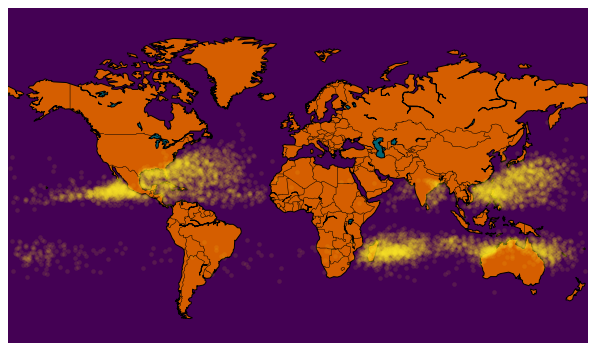

In [29]:
blue, green, red, purple, brown, sky = sns.color_palette('dark')
earth = sns.color_palette('colorblind')[2]
sea = [0.26700401, 0.00487433, 0.32941519] # viridis min
storm = [0.99324789, 0.90615657, 0.1439362] # viridis max

m = Basemap(
    projection='mill', 
    llcrnrlat=-65,
    urcrnrlat=90, 
    llcrnrlon=-180,
    urcrnrlon=180
)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color=earth, lake_color=sky)
m.drawmapboundary(color='w', fill_color=sea)

lngs, lats = locations.values.T
x, y = m(lats, lngs)
m.plot(x, y, '.', alpha=0.1, color=storm)

To estimate the distribution, we stack the `x` and `y` coordinates to get a 2D array, and supply these data to the `scipy.stats.gaussian_kde` function to get a function that can calculate the density for a given location:

In [30]:
h = np.vstack((x, y))
kde = stats.gaussian_kde(h)
print("Density at (0,0): {:.2g}".format(kde((0, 0))[0]))

Density at (0,0): 1e-35


To see the densities on the map, we need to evaluate the `kde` function on a 2D grid spanning the entire map.
We create this grid with `meshgrid`, and we pass the `x` and `y` values to the `kde` function. `kde` accepts a `(2, N)` array as input, requiring us to tweak the shape of the array.

First, the grid must span the entire map (without Anatarctica) so we create the lower-left and upper-right corners in map coordinates:

In [31]:
x0, y0 = m(-180, -65)
x1, y1 = m(180, 85)

We set the north-south resolution to be `k` and the east-west to be `2k`. 

`meshgrid` returns a list of two `(k, 2k)` arrays, the first for the x coordinates and the second for the y coordinates of each point in the grid. We turn this into a `(2, k, 2k)` shaped array, and then reshape it to `(2, 2*k*k)` array, which is what we need for the `kde` function, which expects 2-by-n array.

Let's visualize the grid to make sure we get what we want. 

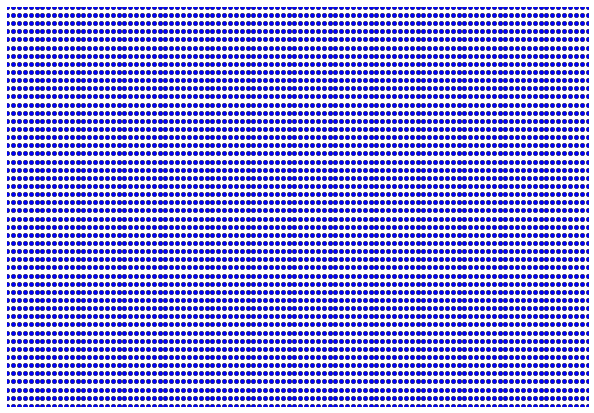

In [32]:
k = 50
grid = np.meshgrid(np.linspace(x0, x1, 2*k), np.linspace(y0, y1, k))
grid = np.array(grid).reshape(2, 2*k*k)

plt.scatter(grid[0,:], grid[1,:])
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.xticks([])
plt.yticks([])
sns.despine(top=True, right=True, left=True, bottom=True)

We use apply `kde` to the grid and reshape it again to k-by-2k array, which we can plot:

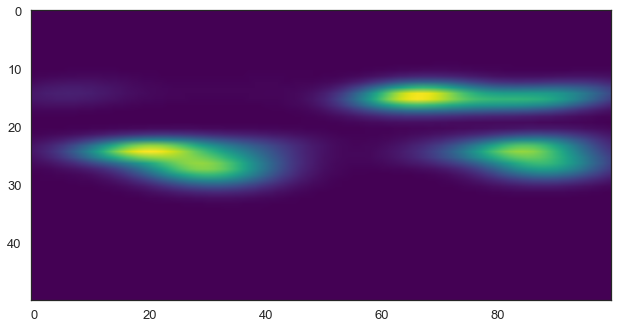

In [33]:
v = kde(grid).reshape((k, 2*k))
plt.imshow(v, cmap='viridis')

Finally, we plot the density map on (or rather under) the geographical map.

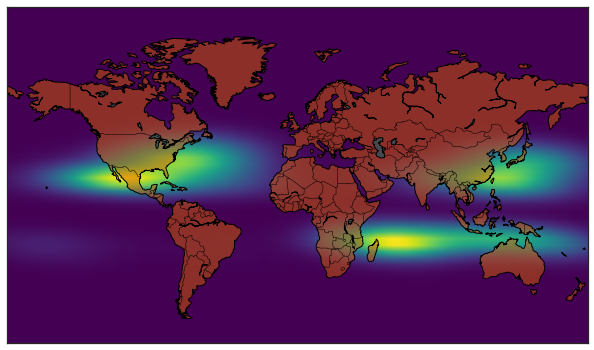

In [35]:
m = Basemap(
    projection='mill', 
    llcrnrlat=-65,
    urcrnrlat=90, 
    llcrnrlon=-180,
    urcrnrlon=180
)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color=earth, lake_color=sky, alpha=0.5)

m.imshow(v, origin='lower', extent=[x0, x1, y0, y1], cmap='viridis');

## Exercise

Consider the following random data, drawn from a 2D normal distribution:

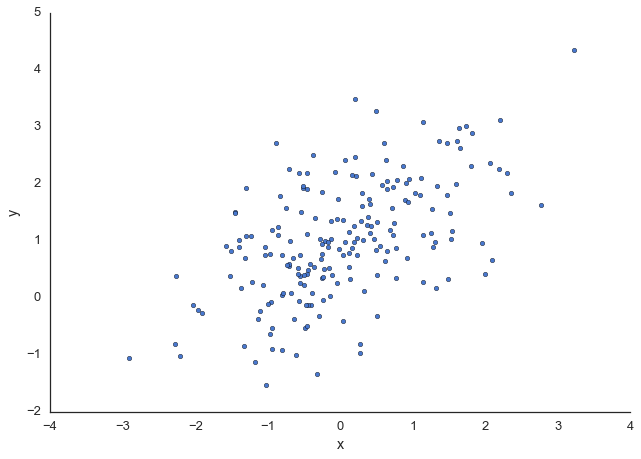

In [36]:
mean, cov = [0, 1], [(1, .5), (.5, 1)]
data = np.random.multivariate_normal(mean, cov, 200)
df = pd.DataFrame(data, columns=["x", "y"])

df.plot.scatter('x', 'y')
sns.despine()

Use a KDE approach to estimate and plot the distribution of the random data. 
**Note** if you only want to plot, rather than actually estimate the `kde` function, you can use Seaborn's [`kdeplot`](http://web.stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html) function. Experiment with the `shade`, `cmap`, and `n_levels` keywords to get aestheticly pleasing results.

# References

- [IPython Cookbook](http://ipython-books.github.io/cookbook/): IPython Interactive Computing and Visualization Cookbook by Cyrille Rossant.
- [scipy.stats tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html)
- [Scipy's statistical functions](http://docs.scipy.org/doc/scipy/reference/stats.html)
- [Visualizing distributions in Seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html)
- [Basemap](http://matplotlib.org/basemap/)

## Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com) and is part of the _Python for Engineers_ course.

The notebook was written using [Python](http://pytho.org/) 3.4.4, [IPython](http://ipython.org/) 4.0.3 and [Jupyter](http://jupyter.org) 4.0.6.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)